Importing Required Libraries which will be used in analysis of Case Study

In [1490]:
#import the Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats .outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score


Reading the dataset and looking at data

In [1491]:
#Read the Bike Usage Data
bikeUsageData = pd.read_csv("day.csv")
bikeUsageData.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Check if there are any Missing Values

In [1492]:
#Check for the null values in the data
bikeUsageData.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Removing the unnecessary Columns as it does not add value in analysis

In [1493]:
#Removing the Unncessary columns which do not add value in analysis, Removing instant, dteday, casual, registered
#Instant is similar to index and does not add value
#dteday is also unique value and can be used as index, but it does not help in analysis.
#if a rider is casual or Registered, it will not help in analysis of total demand.
columns_to_remove = ('instant', 'dteday', 'casual', 'registered')

for col_name in columns_to_remove:
  bikeUsageData = bikeUsageData.drop([col_name], axis=1)



Converting the Categorical Variables  Values to more meaningful Names its having numbers can impact analysis
We would be do this for weekday, season, yr, mnth, weathersit

In [1494]:
#Converting the Categorical variables to meaningful names for better readability

#Convert season to represent weekday for better readbility
columns_to_modify = ['weekday']
bikeUsageData[columns_to_modify] = bikeUsageData[columns_to_modify].apply(lambda x: x.map({0:'Sunday' , 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'}))

#Convert season to Actual Season for better readbility
columns_to_modify = ['season']
bikeUsageData[columns_to_modify] = bikeUsageData[columns_to_modify].apply(lambda x: x.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'}))

#Convert yr to Actual Year for better readbility

columns_to_modify = ['yr']
bikeUsageData[columns_to_modify] = bikeUsageData[columns_to_modify].apply(lambda x: x.map({0: 2018, 1:2019}))

#Convert mnth to actual mnth for better readbility
columns_to_modify = ['mnth']
bikeUsageData[columns_to_modify] = bikeUsageData[columns_to_modify].apply(lambda x: x.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6: 'Jun', 7:'Jul', 8:'Aug', 9:'Sep',10:'Oct', 11:'Nov', 12:'Dec'}))

#Convert weathersit to weather situation for better readbility
columns_to_modify = ['weathersit']
bikeUsageData[columns_to_modify] = bikeUsageData[columns_to_modify].apply(lambda x: x.map({1:'Clear', 2:'Mist', 3:'Light_Snow', 4:'Heavy_Rain'}))


Creating a heatmap to check the correration between varables:

Inference:  
Rentals has good correlation with temp and atemp, so one can be dropped
Rentals has negative correlation with humidity and windspeed

<AxesSubplot:>

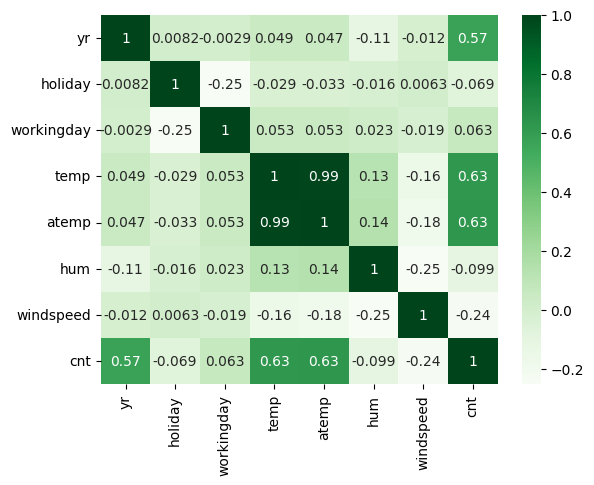

In [1495]:
sns.heatmap(bikeUsageData.corr(),cmap="Greens", annot=True)
#Inference Rentals has good correlation with temp and atemp, so one can be dropped
#Rentals has negative correlation with humidity and windspeed

Dropping atemp which came out to be redundant with temp as part of correlation check

In [1496]:
#Dropping atemp as cnt has similar correlaion with both temp and atemp, dropping one as its redundant
bikeUsageData = bikeUsageData.drop('atemp', axis=1)


Checking the shape for dataframe after dropping columns.
We have 11 coulmns left after dropping 5 columns

In [1497]:
bikeUsageData.shape

(730, 11)

Checking the min max and mean of temp,hum, windspeed and cnt to see if there is any outliers. The Data looks to be clean and not having significant outliers

In [1498]:
#Checking the Data in bikeUsageData
bikeUsageData.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2018.500000,0.028767,0.683562,20.319259,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.465405,7.506729,14.237589,5.195841,1936.011647
min,2018.000000,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000
25%,2018.000000,0.000000,0.000000,13.811885,52.000000,9.041650,3169.750000
50%,2018.500000,0.000000,1.000000,20.465826,62.625000,12.125325,4548.500000
75%,2019.000000,0.000000,1.000000,26.880615,72.989575,15.625589,5966.000000
max,2019.000000,1.000000,1.000000,35.328347,97.250000,34.000021,8714.000000


Visualising tge Numeric Variable to check the correlation    
Inference:  
Usage Looks to be increasing when temperature increases, so cnt is having good correlation with temp, this was confirmed with heatmap as well

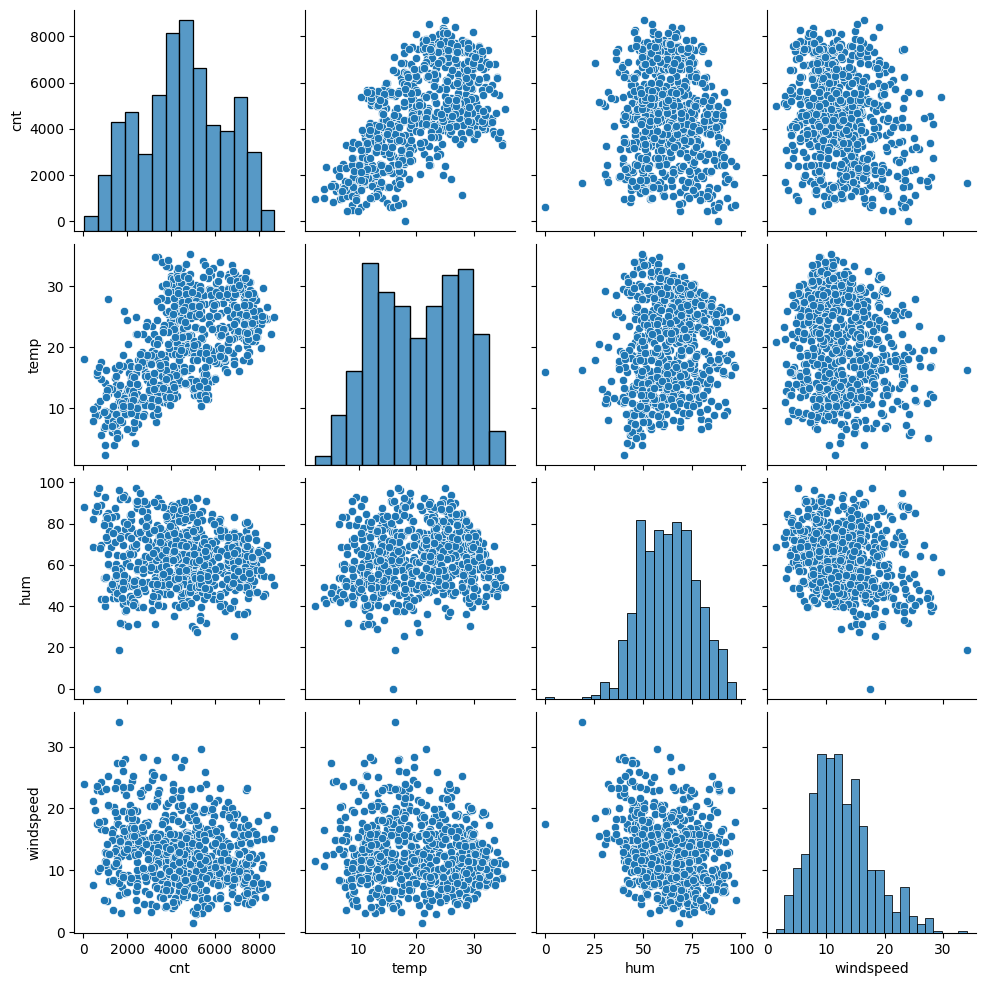

In [1499]:
#Visualising the numeric variables
sns.pairplot(bikeUsageData[['cnt','temp','hum', 'windspeed']])

#Inference: Usage Looks to be increasing when temperature increases, so cnt is having go correlation with temp and atemp

Visulaising the categorical variable which are represented in Numerical form

Inferences:    
Number of Rentals has increased in 2019 compared to 2018.    
Rental Usage starts increasing from begining of year and after mid it starts decreasing, Jun to Oct has maximum usages.    
Usage is comparatively lesser on holidays.    
Mean Rentals are similar on all days, however 25% it is lowest on Saturday and Wednesday.    
Usage is higher when Weather Situation is Clear, in case of Light_Snow its very less while when its heavy rain there is no usage.    

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

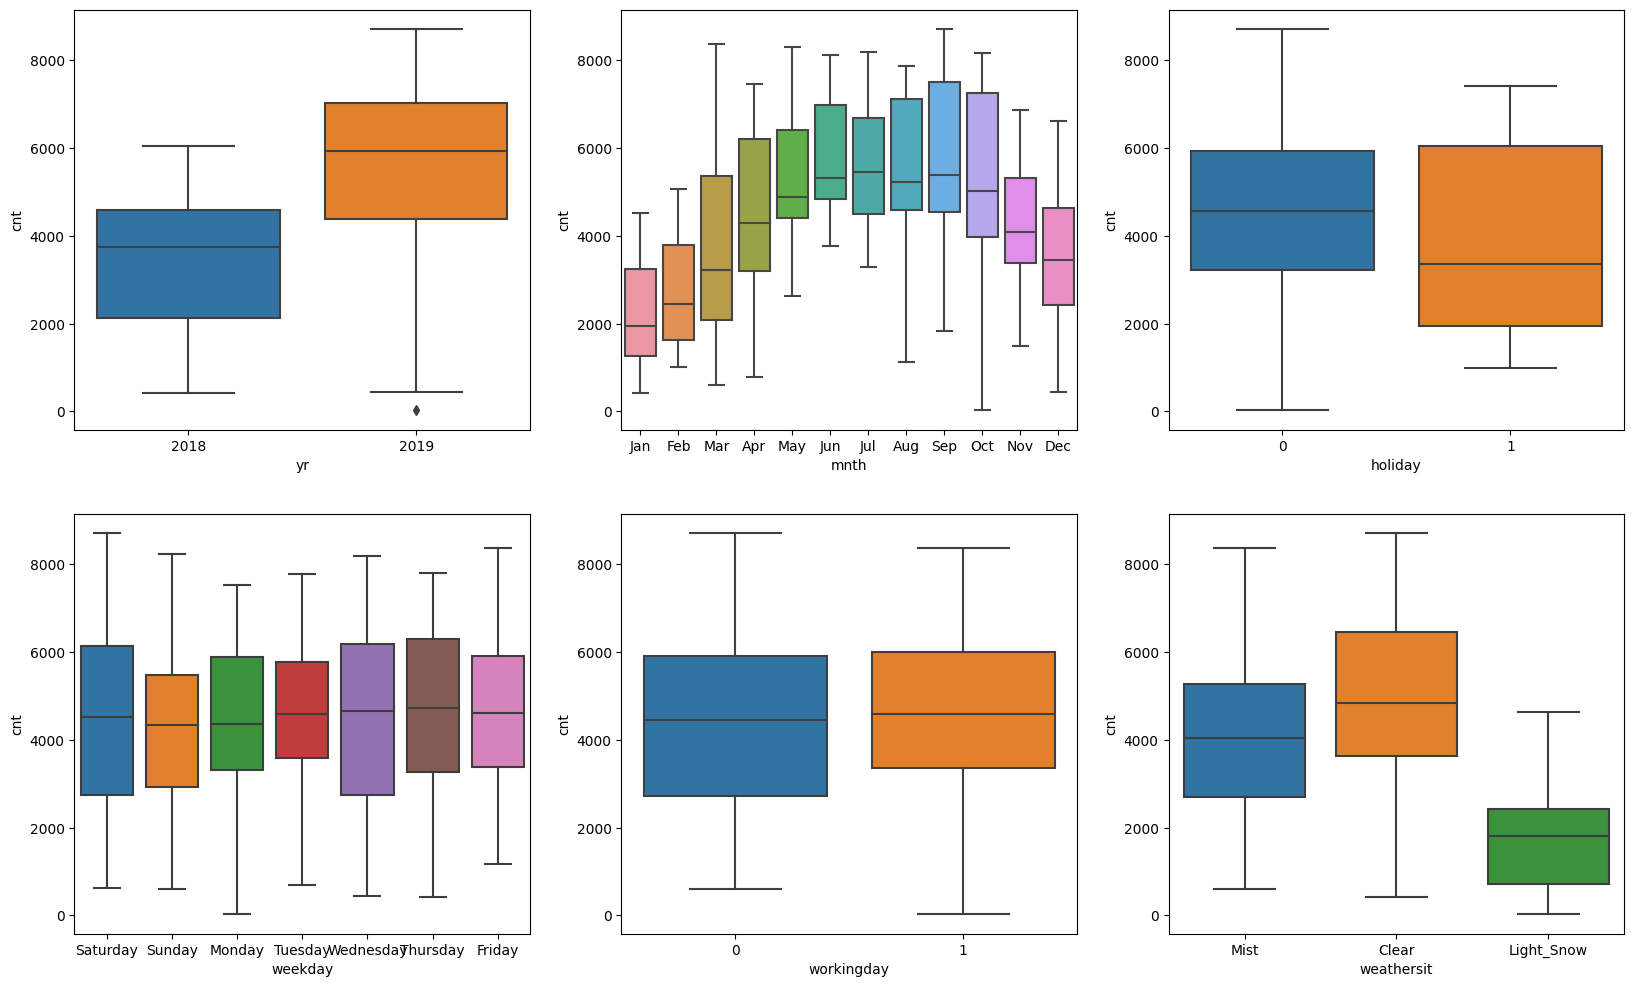

In [1500]:
#visulaising the categorical variable which are represented in Numerical form
plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
sns.boxplot(x="yr", y ="cnt", data=bikeUsageData)

plt.subplot(2,3,2)
sns.boxplot(x="mnth", y ="cnt", data=bikeUsageData)

plt.subplot(2,3,3)
sns.boxplot(x="holiday", y ="cnt", data=bikeUsageData)

plt.subplot(2,3,4)
sns.boxplot(x="weekday", y ="cnt", data=bikeUsageData)

plt.subplot(2,3,5)
sns.boxplot(x="workingday", y ="cnt", data=bikeUsageData)

plt.subplot(2,3,6)
sns.boxplot(x="weathersit", y ="cnt", data=bikeUsageData)


#Inference: Number of Rentals has increased in 2019 compared to 2018
#Rental Usage starts increasing from begining of year and after mid it starts decreasing, Jun to Oct has maximum usages
#Usage is comparatively lesser on holidays
#Mean Rentals are similar on all days, however 25% it is lowest on Saturday and Wednesday
#Usage is higher when Weather Situation is Clear, in case of Light_Snow its very less while when its heavy rain there is no usage

Creating Dummy Variables for weekday,season,yr,mnth,weathersit

In [1501]:
#Convert Weekday to a Dummy Variable and Drop Redundant Dummy Variable
weekday_dummy = pd.get_dummies(bikeUsageData['weekday'], drop_first=True)
bikeUsageData = pd.concat([bikeUsageData, weekday_dummy], axis=1)
bikeUsageData = bikeUsageData.drop('weekday', axis=1)

In [1502]:
#Convert Number of Weekday to actual Days for better readbility

#Convert Weekday to a Dummy Variable and Drop Redundant DUmmy Variable
season_dummy = pd.get_dummies(bikeUsageData['season'], drop_first=True)
bikeUsageData = pd.concat([bikeUsageData, season_dummy], axis=1)
bikeUsageData = bikeUsageData.drop('season', axis=1)

In [1503]:

#Convert Weekday to a Dummy Variable and Drop Redundant DUmmy Variable
yr_dummy = pd.get_dummies(bikeUsageData['yr'], drop_first=True)
bikeUsageData = pd.concat([bikeUsageData, yr_dummy], axis=1)
bikeUsageData = bikeUsageData.drop('yr', axis=1)

In [1504]:
 


#Convert Weekday to a Dummy Variable and Drop Redundant DUmmy Variable
mnth_dummy = pd.get_dummies(bikeUsageData['mnth'], drop_first=True)
bikeUsageData = pd.concat([bikeUsageData, mnth_dummy], axis=1)
bikeUsageData = bikeUsageData.drop('mnth', axis=1)

In [1505]:
 


#Convert Weekday to a Dummy Variable and Drop Redundant DUmmy Variable
weathersit_dummy = pd.get_dummies(bikeUsageData['weathersit'], drop_first=True)
bikeUsageData = pd.concat([bikeUsageData, weathersit_dummy], axis=1)
bikeUsageData = bikeUsageData.drop('weathersit', axis=1)

Checking the Shape of datafram after adding dummies and removing the redundant variables. We now have 29 Columns

In [1506]:
bikeUsageData.shape

(730, 29)

Divide the data into Training Set and Test Set    
Training Set: (510, 29)    
Test Set: (220, 29)

In [1507]:
#Divide the data in Training Set and Test Set
df_train, df_test = train_test_split(bikeUsageData, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


Sacling the Numerical Variables so that it does show a wrong impact when increasing/decreasing a unit.
All the Values will lie between 0 and 1
We will scale following variables: temp, hum, windspeed, cnt
We will go with MinMaxScaling as there were no significant outliers

In [1508]:
#Scaling of the numerical variables
scaler = MinMaxScaler()
varlist_numeric = ['temp', 'hum','windspeed', 'cnt']
df_train[varlist_numeric] = scaler.fit_transform(df_train[varlist_numeric])

Data in temp, hum, windspeed, cnt is scaled and range between 0 and 1

In [1509]:
df_train.head()

,holiday,workingday,temp,hum,windspeed,cnt,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,winter,2019,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Light_Snow,Mist
576,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
426,0,0,0.442393,0.640189,0.255342,0.465255,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
728,0,0,0.245101,0.498067,0.663106,0.204096,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
482,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
111,0,1,0.345824,0.751824,0.380981,0.191095,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Create dataframes with target variables and other Variables

In [1510]:
y_train = df_train.pop('cnt')
X_train = df_train


Create Regression Model and Fit Using Target Variable and Other Variables

In [1511]:

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Select Important Features Using RFE, we will select 50% of features initially i.e., 15

In [1512]:
rfe = RFE(lm, n_features_to_select=15)        
rfe = rfe.fit(X_train, y_train)

Show The Columns along with if its included in above 50% selected features and ranking of all features

In [1513]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Monday', False, 8),
 ('Saturday', True, 1),
 ('Sunday', True, 1),
 ('Thursday', False, 10),
 ('Tuesday', False, 9),
 ('Wednesday', False, 12),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 (2019, True, 1),
 ('Aug', False, 7),
 ('Dec', False, 4),
 ('Feb', False, 5),
 ('Jan', False, 2),
 ('Jul', True, 1),
 ('Jun', False, 13),
 ('Mar', False, 14),
 ('May', False, 6),
 ('Nov', False, 3),
 ('Oct', False, 11),
 ('Sep', True, 1),
 ('Light_Snow', True, 1),
 ('Mist', True, 1)]

Columns which are part of Selected Variables

In [1514]:
col = X_train.columns[rfe.support_]

print(col)

Index([   'holiday', 'workingday',       'temp',        'hum',  'windspeed',
         'Saturday',     'Sunday',     'spring',     'summer',     'winter',
               2019,        'Jul',        'Sep', 'Light_Snow',       'Mist'],
      dtype='object')


Create dataframe with data from training set and variables which are selected as part of RFE

In [1515]:
X_train_rfe = X_train[col]


In [1516]:
## Adding a constant variable and creating Model using ordinary Least Squares Method
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()


In [1517]:
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          2.11e-191
Time:                        16:20:47   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1995      0.028      7.200      0.0

In [1518]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range (X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
1,holiday,inf
2,workingday,inf
6,Saturday,inf
7,Sunday,inf
8,spring,5.02
3,temp,3.62
10,winter,3.49
9,summer,2.62
4,hum,1.91
15,Mist,1.57


On analysis of above VIF and reggression Model Summary, we see holiday is having high p-value and also high VIF, So we need to drop it

In [1519]:
#dropping holiday as holiday is having very hig p-value and also high VIF
X = X_train_rfe.drop('holiday', axis=1)

Recreating the Model after Removing Holiday attribute

In [1520]:
X = sm.add_constant(X)
lm = sm.OLS(y_train,X).fit()
print(lm.summary())


vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          2.11e-191
Time:                        16:20:47   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1811      0.042      4.301      0.0

,Features,VIF
0,const,114.08
1,workingday,9.07
5,Saturday,6.06
6,Sunday,5.74
7,spring,5.02
2,temp,3.62
9,winter,3.49
8,summer,2.62
3,hum,1.91
14,Mist,1.57


p-values looks to be good currently, but VIF is very high for workingday, so we will have to drop it

Recreating the Model after Removing workingday attribute

In [1521]:
X = X.drop('workingday', axis=1)

X = sm.add_constant(X)
lm = sm.OLS(y_train,X).fit()
print(lm.summary())


vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     203.3
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          4.02e-189
Time:                        16:20:47   Log-Likelihood:                 509.40
No. Observations:                 510   AIC:                            -990.8
Df Residuals:                     496   BIC:                            -931.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2804      0.035      8.096      0.0

,Features,VIF
0,const,74.89
6,spring,5.01
1,temp,3.62
8,winter,3.48
7,summer,2.62
2,hum,1.91
13,Mist,1.57
10,Jul,1.49
11,Sep,1.29
12,Light_Snow,1.25


p-value of Saturday looks to be high , So we will have to drop it

Recreating the Model after Removing Saturday attribute

In [1522]:
X = X.drop('Saturday', axis=1)

X = sm.add_constant(X)
lm = sm.OLS(y_train,X).fit()
print(lm.summary())


vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     219.9
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          5.65e-190
Time:                        16:20:47   Log-Likelihood:                 508.62
No. Observations:                 510   AIC:                            -991.2
Df Residuals:                     497   BIC:                            -936.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2839      0.035      8.224      0.0

,Features,VIF
0,const,74.37
5,spring,5.01
1,temp,3.62
7,winter,3.48
6,summer,2.62
2,hum,1.90
12,Mist,1.56
9,Jul,1.49
10,Sep,1.29
11,Light_Snow,1.25


p-value looks to be good , but spring has bit hight VIF, So we will be dropping it.

Recreating Regression Model after dropping spring attribute

In [1523]:
X = X.drop('spring', axis=1)

X = sm.add_constant(X)
lm = sm.OLS(y_train,X).fit()
print(lm.summary())


vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     236.0
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.63e-189
Time:                        16:20:47   Log-Likelihood:                 504.70
No. Observations:                 510   AIC:                            -985.4
Df Residuals:                     498   BIC:                            -934.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2236      0.027      8.278      0.0

,Features,VIF
0,const,44.91
2,hum,1.88
1,temp,1.60
11,Mist,1.55
8,Jul,1.43
5,summer,1.33
6,winter,1.29
10,Light_Snow,1.24
9,Sep,1.19
3,windspeed,1.18


p-value of Jul looks to be slight higher and coeffiecnt is also negative. So we will be dropping it 

In [1524]:
X = X.drop('Jul', axis=1)

X = sm.add_constant(X)
lm = sm.OLS(y_train,X).fit()
print(lm.summary())


vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     256.6
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.73e-189
Time:                        16:20:47   Log-Likelihood:                 501.76
No. Observations:                 510   AIC:                            -981.5
Df Residuals:                     499   BIC:                            -934.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2236      0.027      8.239      0.0

,Features,VIF
0,const,44.91
2,hum,1.86
10,Mist,1.55
1,temp,1.27
6,winter,1.25
9,Light_Snow,1.24
5,summer,1.19
3,windspeed,1.18
8,Sep,1.11
7,2019,1.03


All p-values and VIFs are very low.
Also R2 and Adjusted R-Square is around .83 which a good number

Based on Residual analysis , Error Looks to be normally Distributed

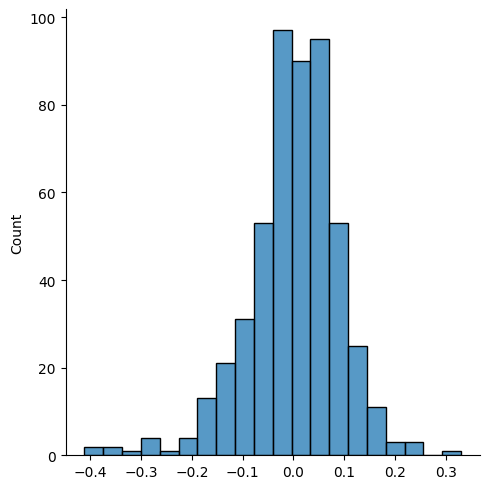

In [1525]:
#Residual Analysis
y_train_pred = lm.predict(X)
res = y_train - y_train_pred
sns.displot(res, bins =20)



Calculate the R2-Score of the training Set.
0.83

In [1526]:
r2_score_train = r2_score(y_true=y_train, y_pred=y_train_pred)

#Transform the Numeric Variables which were transformed in test set as well

In [1527]:
varlist_numeric = ['temp', 'hum','windspeed', 'cnt']
df_test[varlist_numeric] = scaler.transform(df_test[varlist_numeric])
df_test.head()



,holiday,workingday,temp,hum,windspeed,cnt,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,spring,summer,winter,2019,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Light_Snow,Mist
184,1,0,0.831783,0.657364,0.084219,0.692706,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
535,0,1,0.901354,0.610133,0.153728,0.712034,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
299,0,1,0.511964,0.837699,0.334206,0.303382,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
221,0,1,0.881625,0.437098,0.339570,0.547400,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
152,0,1,0.817246,0.314298,0.537414,0.569029,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Create Dataframe of target variable and other variables and drop the variables which were dropped during analysis based on p-values and VIF

In [1528]:
y_test  = df_test.pop('cnt')

X_test = df_test[X_train.columns[rfe.support_]]
X_test = X_test.drop(['spring','workingday', 'holiday', 'Jul', 'Saturday'],axis=1)

In [1529]:
X_test_sm = sm.add_constant(X_test)

y_test_pred = lm.predict(X_test_sm)

X_test_sm.head()

,const,temp,hum,windspeed,Sunday,summer,winter,2019,Sep,Light_Snow,Mist
184,1.0,0.831783,0.657364,0.084219,0,0,0,0,0,0,1
535,1.0,0.901354,0.610133,0.153728,0,1,0,1,0,0,0
299,1.0,0.511964,0.837699,0.334206,0,0,1,0,0,0,1
221,1.0,0.881625,0.437098,0.339570,0,0,0,0,0,0,0
152,1.0,0.817246,0.314298,0.537414,0,1,0,0,0,0,0


In [1530]:

r2_score_test = r2_score(y_true=y_test, y_pred=y_test_pred)

Creating Regplot to see the the best fitted line

<AxesSubplot:xlabel='cnt'>

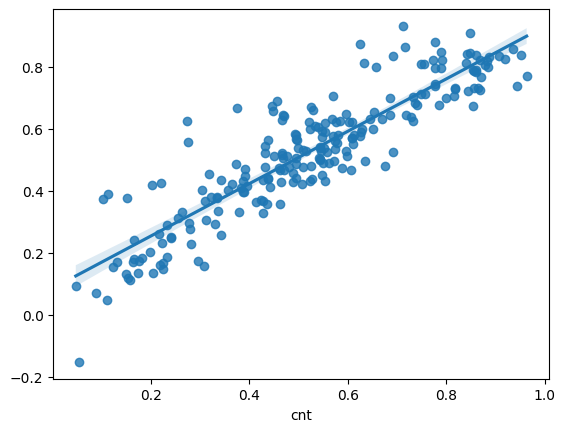

In [1532]:
sns.regplot(x=y_test, y=y_test_pred)

Difference between r2 Scores of Prediction of training Set

In [1533]:
difference = r2_score_train - r2_score_test
print(difference)

0.03402172387444735


Difference between r2_score of Test and Train Sets looks to be around 3% which is lesser than 5%, a good number. So this model can be a good fit.
Formula Can be to calculate count is

cnt= 0.2236 + (temp * 0.5739) + (hum * -0.1676) + (windspeed * -0.1874) + (Sunday * -0.0429) + (summer * 0.0917) + (winter * 0.1389) + (2019 * 0.2293)  + (Sep * 0.1015)  + (Light_Snow * -0.2376) + (Mist * -0.0517)



Creating Scatter Plots to see if there is any visible pattern.. but there is no pattern 

<AxesSubplot:xlabel='cnt'>

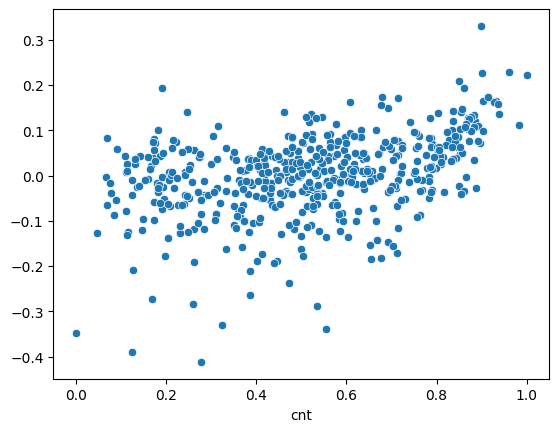

In [1536]:
residual = y_train - y_train_pred
sns.scatterplot(x = y_train, y=residual)